## Phase 1 : Exploration des données (EDA)

### Configuration

In [ ]:
import seaborn as sns 
import matplotlib as plt
import pandas as pd
import numpy as np

DATA_PATH = "../data/"
RAW_FILE = DATA_PATH + "raw/insurance.csv"

True

### Chargement du dataset

In [4]:
df = pd.read_csv(RAW_FILE, sep=",", header=0)

### Apperçu de la structure des données

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Statistiques Descriptives

In [7]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Avec une écart type de `12110.011240`, la colonne `expenses` semble avoir des outliers présente une très grande variation par rapport aux autres caractéristiques. Cela pourrait indiquer :
- Des outliers potentiels, par exemple, des dépenses médicales exceptionnellement élevées pour certains individus.
- Des échelles très différentes : Les valeurs des dépenses sont bien plus grandes que celles des autres variables.

### Distribution des caractéristiques 

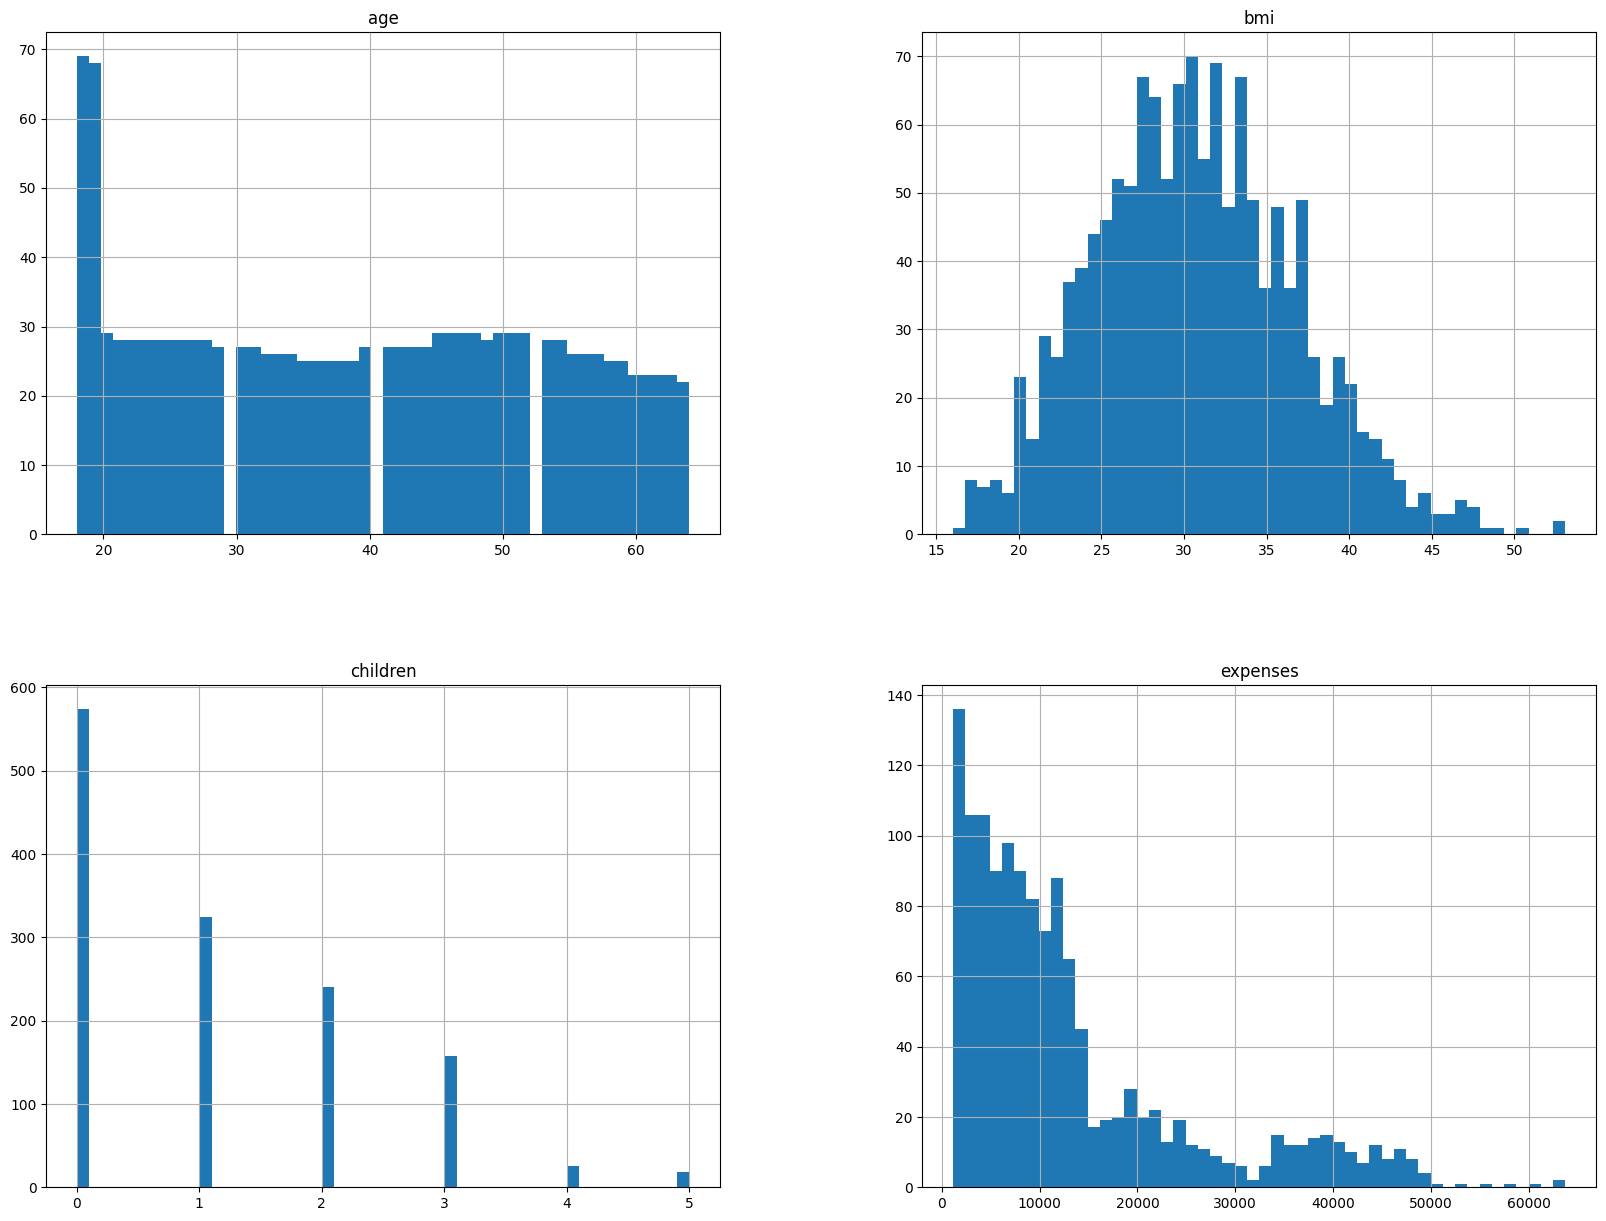

In [8]:
# Insérez votre code ici pour visualiser la distribution des caractéristiques
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

- `age` :
Distribution uniforme avec des pics réguliers, probablement dus à des effets liés à l'échantillonnage.
Relativement symétrique.
- `bmi` :
Ressemble à une distribution normale (en cloche), légèrement asymétrique avec une queue droite plus longue.
Principalement symétrique.
- `children` :
Très asymétrique avec une forte concentration à 0 ou 1 enfant. Peu d'individus ont 4 ou 5 enfants.
Distribution fortement biaisée.
- `expenses` :
Distribution très asymétrique, avec une majorité des données concentrées sur de faibles dépenses, mais une longue queue droite.
Très asymétrique, indiquant des valeurs extrêmes (outliers).

#### Caractéristiques influençant le modèle
- `expenses` :
La grande asymétrie et la présence de valeurs extrêmes pourraient biaiser le modèle si elles ne sont pas traitées. Les modèles sensibles aux échelles (comme les régressions linéaires) pourraient donner trop de poids aux outliers.
- `children` :
La concentration à 0 ou 1 pourrait rendre cette variable peu prédictive, surtout pour les valeurs rares (4 ou 5 enfants).
- `age` et `bmi` :
Ces distributions semblent plus équilibrées et devraient bien fonctionner sans nécessiter de transformations majeures.

#### Outliers potentiels
- `bmi` :
Quelques valeurs élevées (>50) sont rares et pourraient être des outliers.
- `expenses` :
Les dépenses supérieures à 50,000 sont probablement des outliers.
Ces valeurs pourraient influencer les modèles sensibles, comme les arbres de décision ou les régressions.

### Analyse de la Corrélation

Pour faire la matrice de la corrélation sur toutes les colonnes, je dois encoder les colonnes object en numérique

In [12]:
df["sex"].value_counts(), df["smoker"].value_counts(), df["region"].value_counts()

(sex
 male      676
 female    662
 Name: count, dtype: int64,
 smoker
 no     1064
 yes     274
 Name: count, dtype: int64,
 region
 southeast    364
 southwest    325
 northwest    325
 northeast    324
 Name: count, dtype: int64)

- `sex` et `smoker` sera encodé avec LabelEncoder ou map
- `region` sera encodé avec One-Hot Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encodage binaire pour `sex` et `smoker`
le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])
df["smoker"] = le.fit_transform(df["smoker"])

df = pd.get_dummies(df, columns=['region'], drop_first=False)

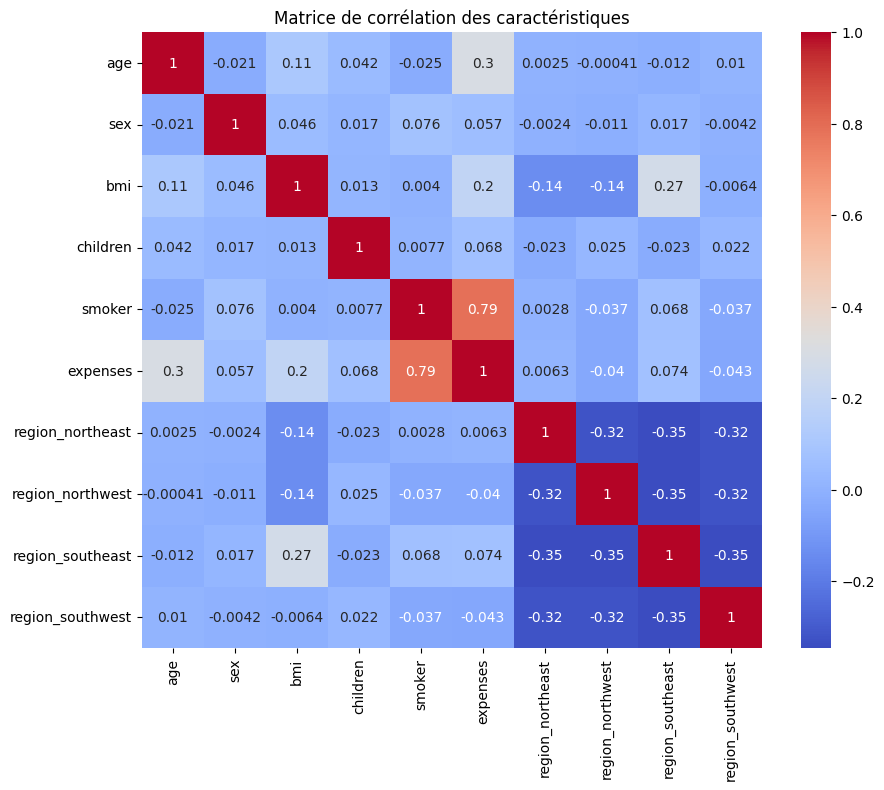

In [ ]:
# Insérez votre code ici pour calculer et visualiser la matrice de corrélation
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation des caractéristiques')
plt.show()

#### Corrélations élevées :
- `smoker` et `expenses` : **0.79**
    - Cela indique que le fait de fumer est fortement corrélé avec les dépenses. Les fumeurs ont probablement des coûts plus élevés.
- `bmi` et `region_southeast` : **0.27**
    - Cela suggère que l'IMC est plus élevé dans cette région, mais la corrélation est modérée.
- `expenses` et `age` : **0.30**
    - Cela signifie que les dépenses médicales ont une relation modérée avec l'âge : plus l'âge augmente, plus les dépenses ont tendance à être élevées.

#### Corrélations avec la cible (`expenses`)
- Corrélations fortes :
    - `smoker` : **0.79** (la plus forte)
        - Être fumeur est le facteur le plus déterminant pour expliquer les dépenses.
    - `age` : **0.30**
        - Les dépenses augmentent avec l'âge, ce qui est logique compte tenu des besoins médicaux croissants.
    - `bmi` : **0.20**
        - Un IMC plus élevé est également associé à des dépenses plus élevées.
- Corrélations faibles :
    - `children`, `sex`, et `region` ont des corrélations faibles avec les dépenses, ce qui suggère qu'elles auront un impact limité sur les prédictions.

### Relation entre les Caractéristiques et la Cible

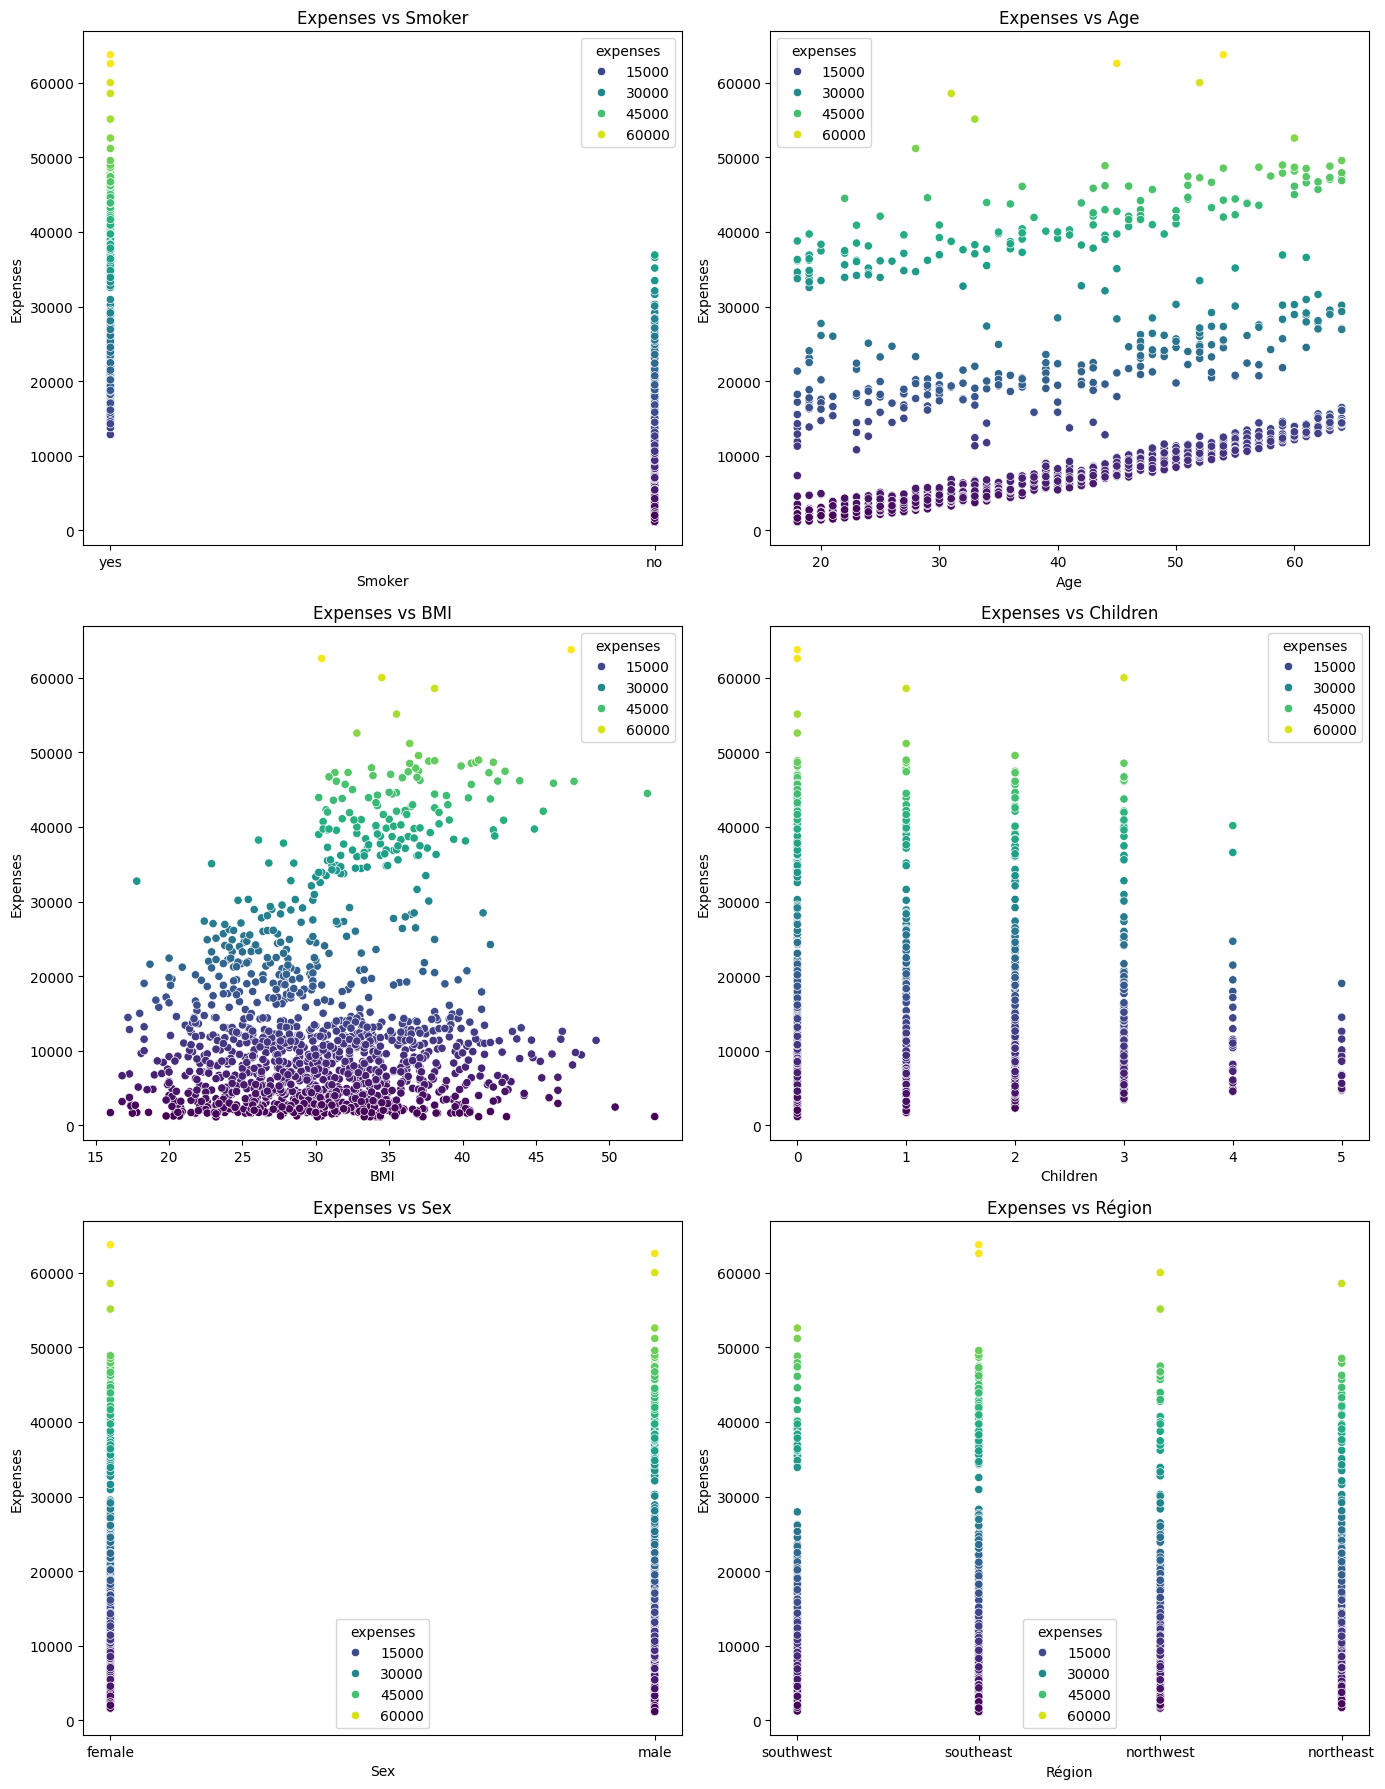

In [35]:
plt.figure(figsize=(14, 18))  # Taille ajustée pour une grille 3x2

# Scatter plot for smoker vs expenses
plt.subplot(3, 2, 1)  # Position 1 dans une grille 3x2
sns.scatterplot(x=df["smoker"], y=df["expenses"], hue=df["expenses"], palette="viridis")
plt.title("Expenses vs Smoker")
plt.xlabel("Smoker")
plt.ylabel("Expenses")

# Scatter plot for age vs expenses
plt.subplot(3, 2, 2)  # Position 2 dans une grille 3x2
sns.scatterplot(x=df["age"], y=df["expenses"], hue=df["expenses"], palette="viridis")
plt.title("Expenses vs Age")
plt.xlabel("Age")
plt.ylabel("Expenses")

# Scatter plot for bmi vs expenses
plt.subplot(3, 2, 3)  # Position 3 dans une grille 3x2
sns.scatterplot(x=df["bmi"], y=df["expenses"], hue=df["expenses"], palette="viridis")
plt.title("Expenses vs BMI")
plt.xlabel("BMI")
plt.ylabel("Expenses")

# Scatter plot for children vs expenses
plt.subplot(3, 2, 4)  # Position 4 dans une grille 3x2
sns.scatterplot(x=df["children"], y=df["expenses"], hue=df["expenses"], palette="viridis")
plt.title("Expenses vs Children")
plt.xlabel("Children")
plt.ylabel("Expenses")

# Scatter plot for sex vs expenses
plt.subplot(3, 2, 5)  # Position 5 dans une grille 3x2
sns.scatterplot(x=df["sex"], y=df["expenses"], hue=df["expenses"], palette="viridis")
plt.title("Expenses vs Sex")
plt.xlabel("Sex")
plt.ylabel("Expenses")

# Scatter plot for region vs expenses
plt.subplot(3, 2, 6)  # Position 5 dans une grille 3x2
sns.scatterplot(x=df["region"], y=df["expenses"], hue=df["expenses"], palette="viridis")
plt.title("Expenses vs Région")
plt.xlabel("Région")
plt.ylabel("Expenses")

# Ajustement de l'espace entre les graphiques
plt.tight_layout()
plt.show()

#### Caractéristiques les plus influentes
- `smoker` :
    - La distinction entre fumeurs et non-fumeurs est la plus marquée. Les fumeurs ont des dépenses nettement plus élevées.
    - Cette caractéristique est probablement la plus influente pour expliquer les frais médicaux.
- `age` :
    - Une relation positive avec expenses, suggérant que l'âge est également une variable importante.
- `bmi` :
    - Bien qu'il y ait de la dispersion, un IMC plus élevé est associé à des dépenses plus importantes, surtout pour les fumeurs.